In [28]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn import metrics
from pathlib import Path
import optuna
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#import eli5
#from eli5.sklearn import PermutationImportance
import shap

# 解决中文乱码问题
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams["axes.unicode_minus"]=False 

In [29]:
data=pd.read_csv('./use.csv')
train_data,test_data=train_test_split(data,test_size=0.2, random_state=1314)
feature=train_data.drop(['Sel','Unnamed: 0'],axis=1)
label=train_data['Sel']

In [30]:
kfold = KFold(n_splits = 5, random_state = 1314, shuffle = True)

In [31]:
def optuna_objective(trial):
    iterations=trial.suggest_int('iterations',100,1000,10)
    max_depth=trial.suggest_int("max_depth",2,25,1)
    lambda_l2=trial.suggest_float("lambda_l2",1,4)
    subsample=trial.suggest_float('subsample',0.3,0.9)
    colsample_bytree=trial.suggest_float('colsample_bytree',0.2,0.8)
    learning_rate=trial.suggest_float("learning_rate",0.05,0.4)
    reg=lgb.LGBMRegressor(iterations=iterations,
                             max_depth=max_depth,
                             lambda_l2=lambda_l2,
                             subsample=subsample,
                             colsample_bytree=colsample_bytree,
                             learning_rate=learning_rate,
                             verbose=-1
                             )
    loss=cross_val_score(reg,feature,label,cv=kfold,error_score='raise')
    return pow(abs(loss.mean()),0.5)

In [143]:
def optimizer_optuna(n_trials):
    algo=optuna.samplers.TPESampler(n_startup_trials=10,n_ei_candidates=24)
    study=optuna.create_study(sampler=algo,direction="maximize")
    study.optimize(optuna_objective,n_trials=n_trials,show_progress_bar=True)
    print("\n","\n","best params: ", study.best_trial.params,
          "\n","\n","best score: ", study.best_trial.values,
          "\n")
    
    return study.best_trial.params, study.best_trial.values

In [144]:
optimizer_optuna(250)

[I 2023-04-27 13:49:40,520] A new study created in memory with name: no-name-f3d5e3cd-c5c3-4a78-8164-3d3222cd0f37
Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/250 [00:00<?, ?it/s]

[I 2023-04-27 13:49:40,746] Trial 0 finished with value: 0.843030130786963 and parameters: {'iterations': 780, 'max_depth': 8, 'lambda_l2': 1.4687963967104953, 'subsample': 0.8483687373504261, 'colsample_bytree': 0.6333805526074971, 'learning_rate': 0.33108239406316464}. Best is trial 0 with value: 0.843030130786963.
[I 2023-04-27 13:49:40,866] Trial 1 finished with value: 0.8162143243252254 and parameters: {'iterations': 690, 'max_depth': 19, 'lambda_l2': 3.3474680401593013, 'subsample': 0.6758989430852707, 'colsample_bytree': 0.2438862452998737, 'learning_rate': 0.23837746250285807}. Best is trial 0 with value: 0.843030130786963.
[I 2023-04-27 13:49:41,025] Trial 2 finished with value: 0.8396833841013811 and parameters: {'iterations': 1000, 'max_depth': 25, 'lambda_l2': 1.9785585199031055, 'subsample': 0.6205393878153505, 'colsample_bytree': 0.6541354503057556, 'learning_rate': 0.1574231753058492}. Best is trial 0 with value: 0.843030130786963.
[I 2023-04-27 13:49:41,154] Trial 3 fin

({'iterations': 480,
  'max_depth': 12,
  'lambda_l2': 3.3623304292402914,
  'subsample': 0.7392826642697368,
  'colsample_bytree': 0.7705855922151122,
  'learning_rate': 0.2852076993094798},
 [0.861843365437098])

In [25]:
feature

,V,Na,Pt,Li,Ni,Sn,K,Hf,Mo,Mg,...,SiO2,BPO4.1,C2H6,C3H8,O2,保护气体,形态,GHSV,温度,Con
440,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,29.58,14.59,55.83,2,26509.106383,440,11.39
177,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,2.44,2.44,95.12,2,18000.000000,500,40.00
31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,40.00,20.00,40.00,1,12000.000000,500,12.00
502,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.52,0.0,...,0.0,0.0,0.0,29.40,9.60,61.00,2,26509.106383,650,5.00
25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,40.00,20.00,40.00,1,12000.000000,500,64.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,10.00,10.00,80.00,2,3600.000000,460,3.00
103,0.0,0.0,0.0,0.0,84.4,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,30.00,15.00,55.00,1,9766.000000,500,4.80
168,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,2.44,2.44,95.12,2,18000.000000,500,40.00
251,2.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,10.00,10.00,80.00,2,72000.000000,550,20.00


In [32]:
model = lgb.LGBMRegressor(random_state=1314,iterations=500,verbose=-1,
                        #   max_depth=21,
                        #   colsample_bytree=0.6996018516903802,subsample=0.360500873673603,
                          lambda_l2=3.6696821767896,learning_rate= 0.4135020975900916).fit(X=feature , y=label)
r2_score = cross_val_score(model, feature, label, cv=kfold, scoring='r2').mean()
rmse_score = pow(abs(cross_val_score(model, feature, label, cv=kfold, scoring='neg_mean_squared_error').mean()),0.5)
print('r2:',r2_score)
print('rmse:',rmse_score)

r2: 0.6929272921925503
rmse: 11.84759079228258


In [33]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
test_x = test_data.drop(['Sel','Unnamed: 0'],axis=1)
test_y = test_data['Sel']
print('r2:',r2_score(label,model.predict(feature)))
print('MAE:',pow(mean_squared_error(label,model.predict(feature)),0.5))
print('测试集得分为：', r2_score(test_y,model.predict(test_x)),pow(mean_squared_error(test_y,model.predict(test_x)),0.5))

r2: 0.9747207056520663
MAE: 3.47173807548856
测试集得分为： 0.8025041386135378 9.525400510193586


In [34]:
# 预测1
Y1=model.predict(test_data.drop(['Sel','Unnamed: 0'],axis=1))
Y2=test_data['Sel']
d={'Y_pred':Y1,
   'Y_True':Y2
   }
pred_show=pd.DataFrame(d)

In [35]:
# 预测2
Y_1=model.predict(feature)
Y_2=label
d_1={'Y_pred':Y_1,
   'Y_True':Y_2
   }
pred_show_1=pd.DataFrame(d_1)

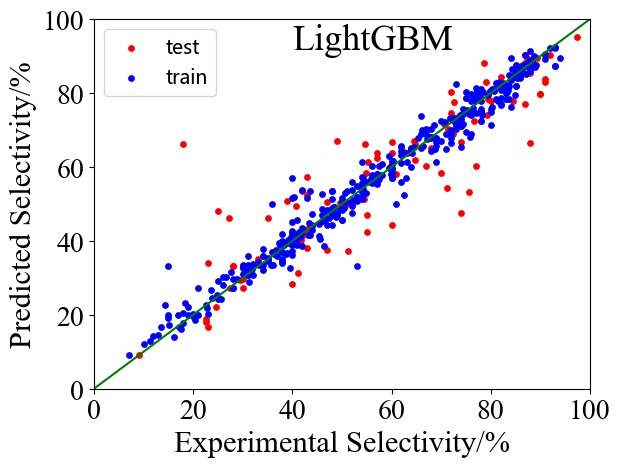

In [36]:
plt.scatter(pred_show.iloc[:,1],pred_show.iloc[:,0],color='r',s=15,label='test')
plt.scatter(pred_show_1.iloc[:,1],pred_show_1.iloc[:,0],color='b',s=15,label='train')
plt.xlim((0,100))
plt.xlabel('Experimental Selectivity/%',fontsize=22,font=Path('..\TimesNewRoman.ttf'))
plt.xticks(fontsize=20,fontname='Times New Roman')
plt.ylim((0,100))
plt.ylabel('Predicted Selectivity/%',fontsize=22,font=Path('..\TimesNewRoman.ttf'))
plt.yticks(fontsize=20,fontname='Times New Roman')
plt.plot([0,100],[0,100],color='g')
plt.text(40,92,'LightGBM',fontsize=26,font=Path('..\TimesNewRoman.ttf'))
plt.legend(fontsize=14)
plt.show()

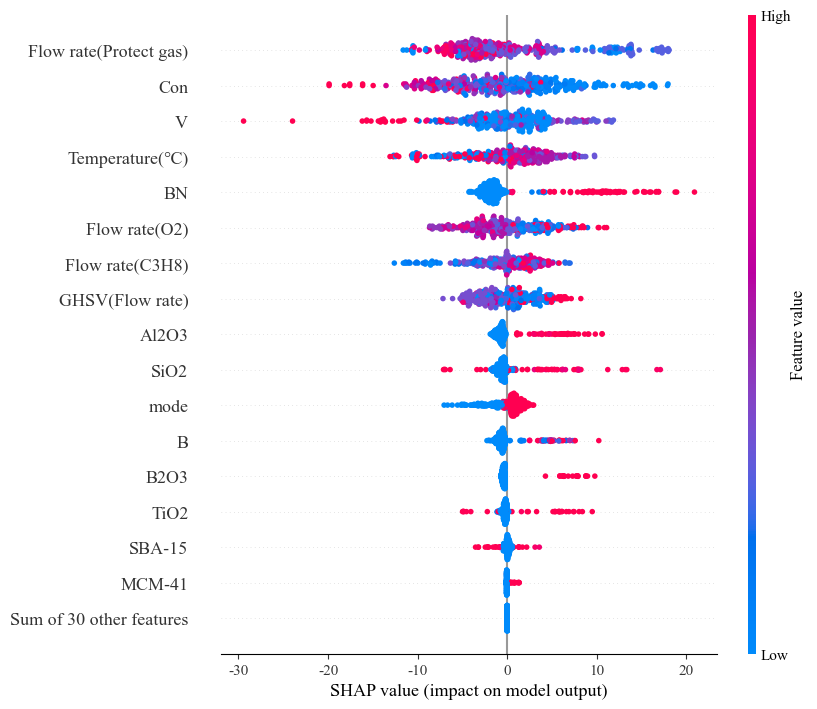

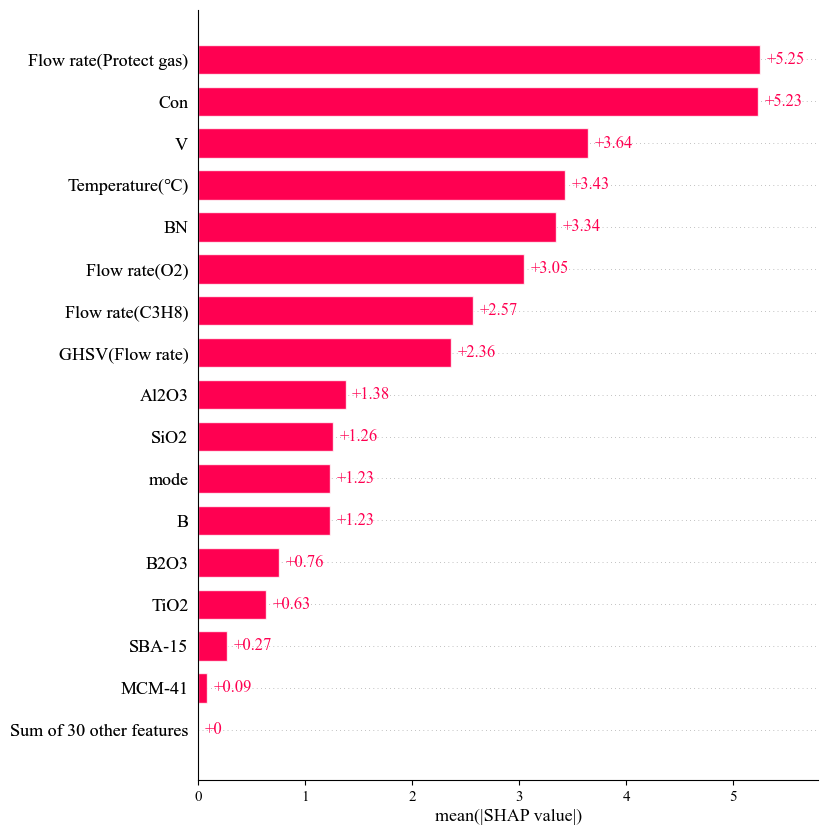

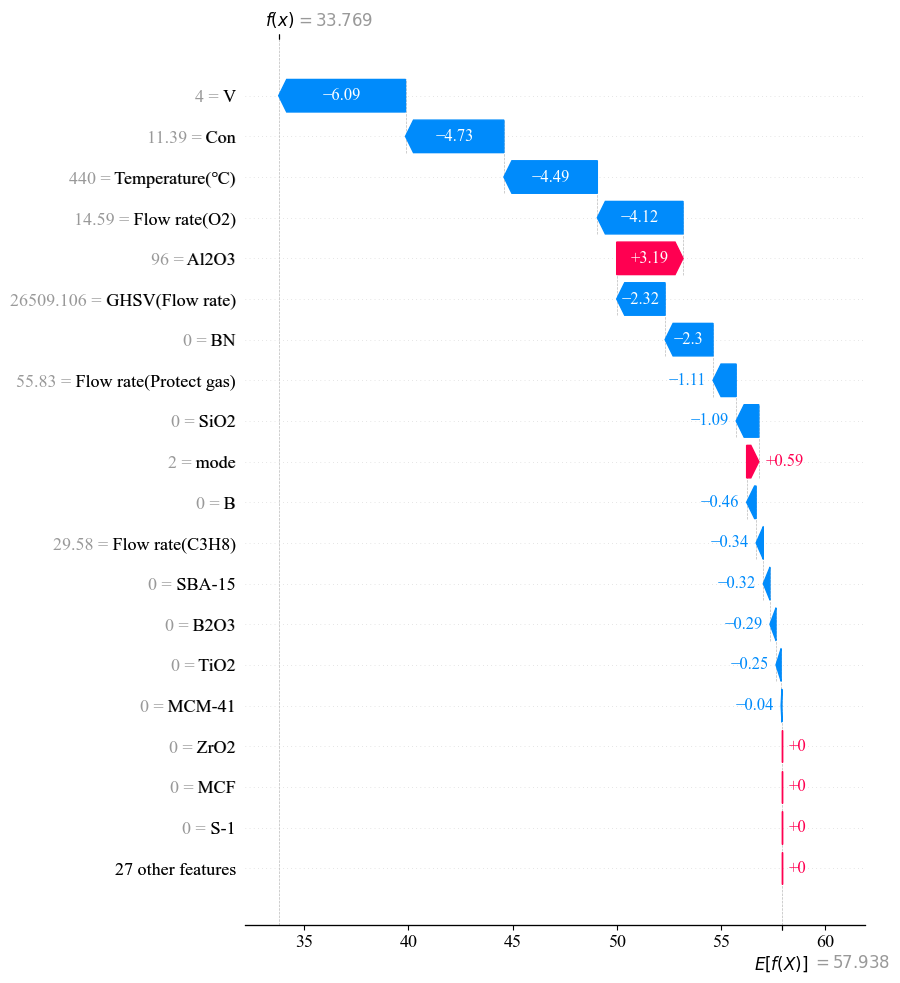

In [38]:
# shap提高解释性
shap.initjs()
font = {'family': 'Times New Roman', 'size': 12}
plt.rc('font', **font)
explainer = shap.TreeExplainer(model)
shap_values = explainer(feature)
shap.plots.beeswarm(shap_values, max_display=17)
shap.plots.bar(shap_values, max_display=17)
shap.plots.waterfall(shap_values[0], max_display=20)
shap.plots.force(shap_values[0])
shap.force_plot(explainer.expected_value, shap_values.values, feature)

In [179]:
perm = PermutationImportance(model, random_state=1).fit(test_x, test_y)
eli5.show_weights(perm, feature_names = test_x.columns.tolist())

Weight,Feature
0.3617 ± 0.0729,V
0.3385 ± 0.0908,Con
0.2886 ± 0.0641,保护气体
0.1847 ± 0.0701,O2
0.1823 ± 0.0926,温度
0.1169 ± 0.0183,C3H8
0.1024 ± 0.0451,BN
0.0866 ± 0.0261,Al2O3
0.0642 ± 0.0277,SiO2
0.0443 ± 0.0354,GHSV
